# Анализ рынка компьютерных игр

Были собраны исторические данные о продажах компьютерных игр, оценки пользователей и критиков, жанры и платформы.  

Описание данных:
- Name — название игры
- Platform — платформа
- Year_of_Release — год выпуска
- Genre — жанр игры
- NA_sales — продажи в Северной Америке (миллионы проданных копий)
- EU_sales — продажи в Европе (миллионы проданных копий)
- JP_sales — продажи в Японии (миллионы проданных копий)
- Other_sales — продажи в других странах (миллионы проданных копий)
- Critic_Score — оценка критиков (максимум 100)
- User_Score — оценка пользователей (максимум 10)
- Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board).

*Примечание:* Данные за 2016 год могут быть неполными.

**Цель** - определить факторы, влияющие на успешность игры.  

Это позволит сделать ставку на определенные игры. Также это позволит на основании исторических данных прогнозировать продажи на будующий период.

**План**:
1. <a href="#Импорт-библиотек-и-загрузка-датасета">Загрузить данные и взглянуть на них</a>
2. <a href="#Предобработка-данных">Провести предобработку данных</a>
3. <a href="#Исследовательский-анализ-данных">Провести исследовательский анализ данных</a>
4. <a href="#Портрет-пользователя-для-каждого-региона">Составить портрет рынка для каждого региона</a>
5. <a href="#Проверка-гипотез">Проверить гипотезы</a>

### Импорт библиотек и загрузка датасета

Импорт необходимых библиотек

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import stats as st

import plotly.express as px

Загрузка датасета.

In [2]:
games = pd.read_csv('/datasets/games.csv')

### Первый взгляд на данные

Взглянем на данные. Выведем несколько строк таблицы, посмотрим информацию о столбцах таблицы.

In [3]:
display(games.head(10))
games.info()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Вывод

При рассмотрении столбцов таблицы возникло ощущение, что эта таблица составлена по мотивам сайта metacritic.com. Скорее всего датасет либо целиком, либо полностью выгружен именно с этого сайта. Данное предположение сделано на основании того, что оценки некоторых игр, таинственное значение 'tbd' в столбцах с рейнтингом и столбец с рейтингом совпадают с оценками и рейтингами той же игры на сайте metacritic.  
Возможно эта информация поможет с заполнением пропусков.  

Датасет достаточно маленький, всего 16715 строк и 11 столбцов.  

В 6-ти столбцах наблюдаются пропуски. Отдельно стоит отметить, что в столбцах Name и Genre ровно по 2 пропуска.  

Названия столбцов начинаются с большой буквы, стоит это поправить, приведя все названия к нижнему регистру.  

Значения в стобцах Year_Of_Release и Critic_Score, судя по всему, должны быть целочисленными. А в данный момент они представлены вещественными числами, так как в этих столбцах присутствуют пропуски. Необходимо с этим разобраться.  

В датасете достаточно много текстовых столбцов, содержимое которых необходимо привести к нижнему регистру.  

После всех операций необходимо проверить наличие дубликатов и обработать их, если таковые обнаружатся.

### Предобработка данных

План на предобработку данных:
1. Переименование столбцов
2. Обработка пропусков
3. Приведение значений всех текстовых столбцов к нижнему регистру
4. Замена типов данных
5. Обработка дубликатов

#### Переименование столбцов

Переименуем столбцы. Все названия приведем к нижнему регистру. Столбец Year_Of_Release переименуем в release_year, Critic_Score в critics_score, User_Score в users_score.  

In [4]:
games.set_axis(['name', 'platform', 'release_year', 'genre', 'na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'critics_score', 'users_score', 'rating'], axis=1, inplace=True)
list(games.columns)

['name',
 'platform',
 'release_year',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critics_score',
 'users_score',
 'rating']

#### Обработка пропусков

Начнем со столбцов name и genre. Посмотрим на строки с пропусками в этих столбцах.

In [5]:
games[games['name'].isna()]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critics_score,users_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


In [6]:
games[games['genre'].isna()]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critics_score,users_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Как видно, пропуски в этих столбцах наблюдаются в одних и тех же записях. Таких записей всего 2, можно смело избавиться от них.

In [7]:
games.drop(games[games['name'].isna()].index, inplace=True)

games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
name             16713 non-null object
platform         16713 non-null object
release_year     16444 non-null float64
genre            16713 non-null object
na_sales         16713 non-null float64
eu_sales         16713 non-null float64
jp_sales         16713 non-null float64
other_sales      16713 non-null float64
critics_score    8137 non-null float64
users_score      10014 non-null object
rating           9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Пропуски остались в следующих столбцах:
- release_year
- critics_score
- users_score
- rating  

Исследуем пропуски в столбце **release_year**.

In [8]:
games[games['release_year'].isna()]

,name,platform,release_year,genre,na_sales,eu_sales,jp_sales,other_sales,critics_score,users_score,rating
183,Madden NFL 2004,PS2,NaN,Sports,4.26,0.26,0.01,0.71,94.0,8.5,E
377,FIFA Soccer 2004,PS2,NaN,Sports,0.59,2.36,0.04,0.51,84.0,6.4,E
456,LEGO Batman: The Videogame,Wii,NaN,Action,1.80,0.97,0.00,0.29,74.0,7.9,E10+
475,wwe Smackdown vs. Raw 2006,PS2,NaN,Fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN
609,Space Invaders,2600,NaN,Shooter,2.36,0.14,0.00,0.03,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16373,PDC World Championship Darts 2008,PSP,NaN,Sports,0.01,0.00,0.00,0.00,43.0,tbd,E10+
16405,Freaky Flyers,GC,NaN,Racing,0.01,0.00,0.00,0.00,69.0,6.5,T
16448,Inversion,PC,NaN,Shooter,0.01,0.00,0.00,0.00,59.0,6.7,M
16458,Hakuouki: Shinsengumi Kitan,PS3,NaN,Adventure,0.01,0.00,0.00,0.00,NaN,NaN,NaN


In [9]:
print(f'Пропущено {games[games["release_year"].isna()].shape[0] / games.shape[0]:.2%} значений.')

Пропущено 1.61% значений.


С одной стороны, год релиза игры пропущен у небольшого количества игр. С другой стороны, среди этих игр есть крайне популярные игры, которые могут оказать сильное влияние на некоторые исследуемые факторы успеха игры.  

Закономерностей, позволивших бы заполнить или еще каким-то образом обработать данные пропуски, не было найдено.  

Обнаружить закономерности в пропусках в столбцах **critics_score** и **users_score** не удалось. В данных столбцах очень большое количество пропусков, поэтому что-то с ними сделать мы не можем.  
Оставим эти пропуски без изменения, при необходимости будем брать срез без пропусков.

Для дальнейшего анализа необходимо заполнить пропуски в столбце **rating**. Как то восполнить пропуски возможности нет. Поэтому заполним пропуски строкой "рейтинг не определен". Это поможет хотя бы выделить пласт игр, рейтинг для которых не определен.

In [10]:
games['rating'] = games['rating'].fillna('рейтинг не определен')

#### Обработка значений столбцов  

В рамках данного раздела необходимо посмотреть на значения, встречающиеся в столбцах с текстовой информацией, поскольку там могут быть скрытые дубликаты или ошибочные данные.  
Проверим числовые столбцы на адекватность встречающихся в них значений.  

Переведем все текстовые столбцы в нижний регистр.

In [11]:
for column in ['name', 'platform', 'genre', 'rating']:
    games[column] = games[column].str.lower()

Ранее можно было заметить, что столбец **users_score** содержит текстовые значения, хотя должен содержать значения типа float.  
Причина - значения 'tbd'. Данная строка является сокращением 'To Be Determined'. То есть оценки для данной игры еще не были получены в достаточном объеме.  

Заменим значения 'tbd' на None и переведем значения столбца из строкового представления числа в формат вещественного числа.

In [12]:
games['users_score'].replace('tbd', float('nan'), inplace=True)
games['users_score'] = pd.to_numeric(games['users_score'])

In [13]:
games['users_score'].dtypes

dtype('float64')

Посмотрим на значения столбца **rating**.

In [14]:
games['rating'].value_counts()

рейтинг не определен    6764
e                       3990
t                       2961
m                       1563
e10+                    1420
ec                         8
k-a                        3
rp                         3
ao                         1
Name: rating, dtype: int64

Каждое значение - сокращение названия определенной возрастной группы:
- e - Everyone (6+)
- t - Teen (13+)
- m - Mature (17+)
- e10+ - Everyone 10 and older (10+)
- ec - Early childhood (3+)
- k-a - Первоначальное название группы Everyone
- rp - Rating Pending - Ожидание рейтинга
- ao - Adults only (18+)

Необходимо значения 'k-a' заменить на 'e'.

In [15]:
games['rating'].replace('k-a', 'e', inplace=True)

Добавим в таблицу столбец с суммарными продажами.

In [16]:
games['total_sales'] = games[['na_sales', 'eu_sales', 'jp_sales']].sum(axis=1)

#### Вывод

Была проведена предобработка данных.  
Пропуски заполнены не были, так как нет возможности их заполнить адекватно, не повлияв на результаты дальнейшего анализа.  
Были удалены 2 строки с пропущенными названиями игр. Эти пропуски можно списать на случайные ошибки.

Учитывая характер таблицы, можно сделать предположение, что пропуски в таблице появились в результате склеивания (merge) двух таблиц. Возможно первая таблица содержала названия игр и данные о продажах, а вторая таблица содержала оценки критиков, пользователей и рейтинг.  
Другие возможные причины: использование каких-нибудь фильтров при выгрузке оценок. Пропусков слишком много, чтобы объяснять пропуски каким-то ошибками при сборе данных.  

Названия столбцов таблицы были приведены к нижнему регистру, как и текстовые значения столбцов.  

Все столбцы содержат адекватные значения. 

Был добавлен отдельный столбец **total_sales**

### Исследовательский анализ данных

Построим гистограмму по годам выпуска игр.

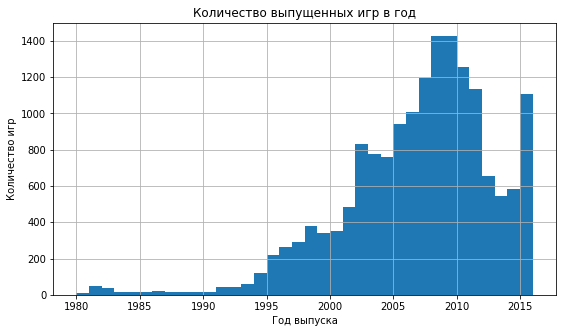

In [17]:
games['release_year'].hist(bins=36, figsize=(9, 5))
plt.xlabel('Год выпуска')
plt.ylabel('Количество игр')
plt.title('Количество выпущенных игр в год')
plt.show()

Больше всего игр издавалось в период с 2007 года по 2011 год. В 2016 году наблюдается рост числа выпущенных игр.  
Пик в период с 2007 года по 2011 год можно объяснить тем, что в начале этого периода поступили в продажу крайне популярные игровые консоли PlayStation3 (PS3) и Xbox 360.  

Больше всего нас интересует период начинающийся с 2013 года. Примерно в то время вышли консоли новейшего (с точки зрения датасета) консоли.

Проанализируем изменение количества продаж по платформам с течением времени.

In [18]:
top_10_popular_platforms = list(games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index)

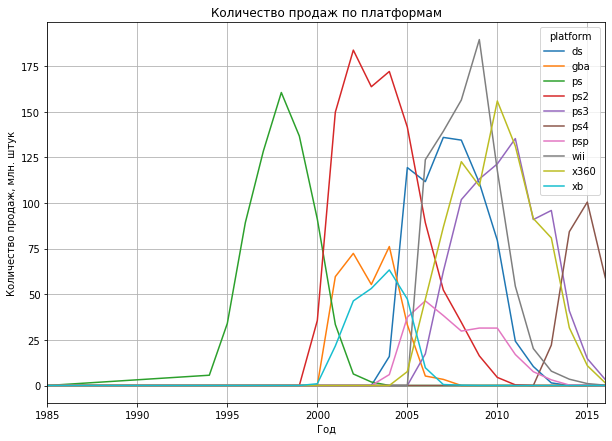

In [19]:
games[games['platform'].isin(top_10_popular_platforms)].pivot_table(
    index='platform', 
    columns='release_year', 
    values='total_sales', 
    aggfunc='sum'
).fillna(0).T.plot(grid=True, figsize=(10, 7))
plt.xlabel('Год')
plt.ylabel('Количество продаж, млн. штук')
plt.title('Количество продаж по платформам')
plt.show()

Обратим внимание на графики продаж игр для игровых приставок PlayStation (ps, ps2, ps3, ps4). По их графикам видно, что между началами продаж игр на каждую из этих консолей проходит примерно 5-7 лет.  
Похожая картина наблдюдается для приставок серии Xbox.  

**Среднее время жизни консолей** - 5-7 лет.

Важная задача - выбрать **актуальный период**. Это такой период, данные за который могут помочь построить прогноз на 2017 год. В качестве актуального периода выберем период, соответствующий периоду популярности платформ, современных на 2016 год.  
Актуальный период: с 2012-2013 года по 2017-2020 год.  

Возьмем срез, содержащий только актуальные для нашего исследования данные.

In [20]:
actual_games = games[games['release_year'] >= 2012]

Для актуального периода построим графики количества продаж игр для каждой платформы.

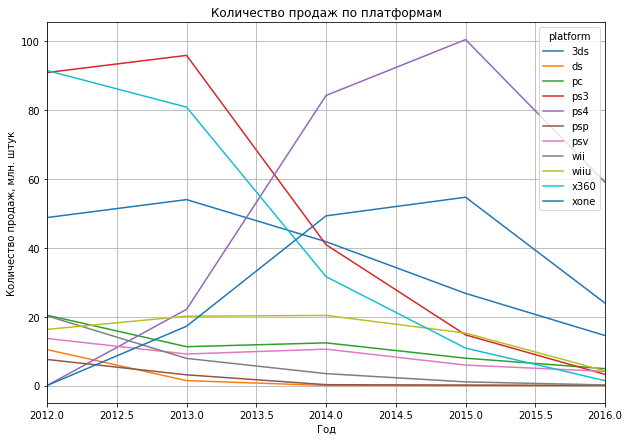

In [21]:
actual_games.pivot_table(
    index='platform', 
    columns='release_year', 
    values='total_sales', 
    aggfunc='sum'
).fillna(0).T.plot(grid=True, figsize=(10, 7))
plt.xlabel('Год')
plt.ylabel('Количество продаж, млн. штук')
plt.title('Количество продаж по платформам')
plt.show()

Можно выделить группу платформ, популярность которых стремится к нулю. На них точно не стоит делать ставку.  
Стоит выделить 3 платформы, которые популярнее остальных. Это PlayStation4 (ps4), Xbox One (xone), 3DS (3ds). При чем PlayStation4 гораздо популярнее всех остальных.  

Платформа 3DS отличается от остальных, так как она является портативной. Данный тип платформ не поддерживает многие игры.

Нельзя забывать и про платформу pc (Персональные компьютеры). Эта платформа менее популярна, чем консоли, но она популярная всегда, в отличии от разных поколений консолей.  

Заметно, что количество продаж снижается для каждой платформы. Это связано с тем, что 2016 год уже близок к концу эпохи консолей данного поколения. И многие издатели уже ориентируются на консоли следующего поколения.  

4 платформы, на которые стоит ориентироваться: PlayStation4, Xbox One, 3DS, PC. 

Построим boxplot'ы продаж по каждой из платформ.

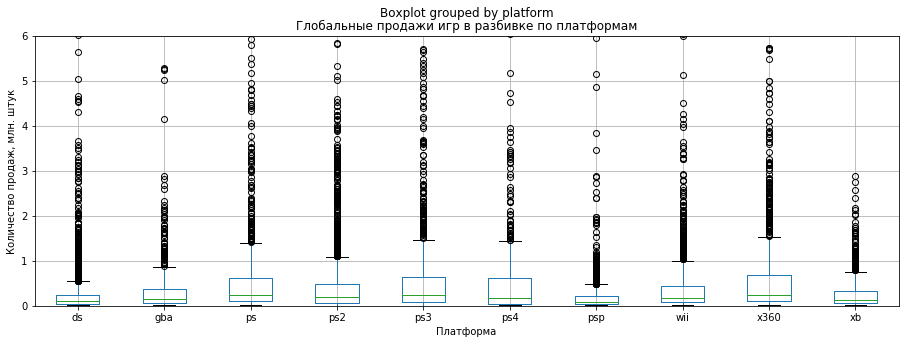

In [22]:
import warnings
warnings.filterwarnings('ignore')

top_10_popular_platforms = list(games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).head(10).index)

games[games['platform'].isin(top_10_popular_platforms)].boxplot('total_sales', by='platform', figsize=(15, 5))
plt.ylim(0, 6)
plt.xlabel('Платформа')
plt.ylabel('Количество продаж, млн. штук')
plt.title('Глобальные продажи игр в разбивке по платформам')
plt.show()

На графике представлены 10 самых популярных платформ.  
В отдельную группу можно вынести платформы ps, ps2, ps3, ps4, wii и x360. Игры для этих платформ покупаются достаточно хорошо. У этих платформ большое количество выбросов, что говорит нам о наличии большого количества крайне популярных игр.  
Отдельного упоминания заслуживают мобильные игровые платформы (ds, gba и psp). Тот факт, что данные платформы попали в топ-10 популярных платформ, говорит нам о том, что мобильный гейминг - живой сегмент. Хотя многие думают иначе.

Оценим влияние оценок критиков и пользователей на продажи. Посмотрим корреляцию на примере платформы PlayStation4 (ps4). Построим диаграмму рассеяния и таблицу корреляции.  

Возьмем срез, отбросив неопределенные значения. Разница в количестве пропусков в столбцах с оценками небольшая, поэтому можно можно отбросить строки, в которых пропущена хотя бы одна из оценок.

In [23]:
actual_games_not_nan = actual_games[actual_games['critics_score'].notna() & actual_games['users_score'].notna()]

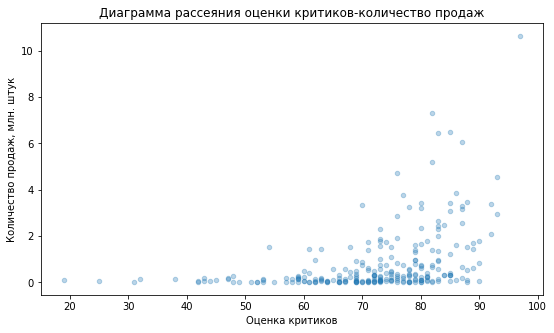

In [24]:
actual_games_not_nan[actual_games['platform'] == 'ps4'].plot(kind='scatter', x='critics_score', y='total_sales', alpha=0.3, figsize=(9, 5))
plt.xlabel('Оценка критиков')
plt.ylabel('Количество продаж, млн. штук')
plt.title('Диаграмма рассеяния оценки критиков-количество продаж')
plt.show()

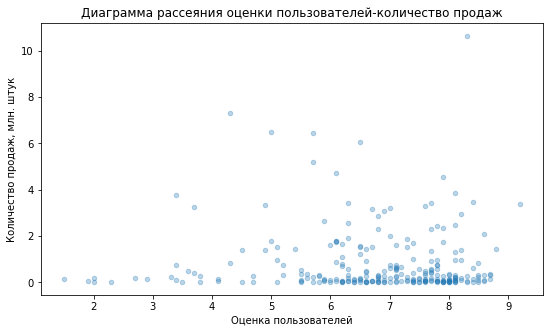

In [25]:
actual_games_not_nan[actual_games['platform'] == 'ps4'].plot(kind='scatter', x='users_score', y='total_sales', alpha=0.3, figsize=(9, 5))
plt.xlabel('Оценка пользователей')
plt.ylabel('Количество продаж, млн. штук')
plt.title('Диаграмма рассеяния оценки пользователей-количество продаж')
plt.show()

In [26]:
print('Таблица корреляции параметра total_sales с параметрами users_score и critics_score для платформы ps4')
corr_table = pd.DataFrame(
    actual_games_not_nan[actual_games_not_nan['platform'] == 'ps4'].loc[:, ['critics_score', 'users_score', 'total_sales']]
    .corr()['total_sales']
).reset_index().loc[0:1]
corr_table.set_axis(['param', 'total_sales'], axis='columns', inplace=True)
corr_table

Таблица корреляции параметра total_sales с параметрами users_score и critics_score для платформы ps4


,param,total_sales
0,critics_score,0.405223
1,users_score,-0.032923


2 факта:
- Влияние оценок критиков на продажи игры на платформе PS3 гораздо сильнее, чем влияние оценок пользователей
- Влияние оценок критиков всё равно не очень большое  

Первый факт можно объяснить тем, что пользователь, который думает купить ли ему какую-то игру или нет, скорее будет доверять мнению критика, чем другого пользователя.  
Второй факт объясняется тем, что мнение критиков всё равно субъективно. Часто бывает, что на мнение критиков сильно влияют компании, выпускающие игры.  

Если говорить об оценках критиков, то можно сделать главный вывод: игра с плохими оценками точно не будет популярна.

Посмотрим на коэффициенты корреляции между исследуемыми параметрами для всех платформ.

In [27]:
print('Таблица корреляции параметра total_sales с параметрами users_score и critics_score для всех платформ')
corr_table = pd.DataFrame(
    actual_games_not_nan.loc[:, ['critics_score', 'users_score', 'total_sales']]
    .corr()['total_sales']
).reset_index().loc[0:1]
corr_table.set_axis(['param', 'total_sales'], axis='columns', inplace=True)
corr_table

Таблица корреляции параметра total_sales с параметрами users_score и critics_score для всех платформ


,param,total_sales
0,critics_score,0.307748
1,users_score,0.002682


Влияние оценок в общем ниже, чем для платформы ps4, однако разница в уровне влияния между пользовательскими оценками и оценками критиков сохраняется.

Посмотрим на **распределение игр по жанрам**. Составим таблицу, построим круговую диаграмму суммарного количества проданных игр каждого жанра и построим столбчатую диаграмму медианного количества проданных игр каждого жанра.

In [28]:
actual_games_genres = actual_games.pivot_table(index=['genre'], values='total_sales', aggfunc=['sum', 'median']).reset_index()
actual_games_genres.set_axis(['genre','total_sales_sum', 'total_sales_median'], axis = 'columns')
actual_games_genres

,genre,total_sales_sum,total_sales_median
0,action,389.98,0.110
1,adventure,26.62,0.030
2,fighting,40.02,0.130
3,misc,77.37,0.120
4,platform,55.42,0.190
5,puzzle,4.67,0.040
6,racing,47.01,0.120
7,role-playing,177.97,0.135
8,shooter,267.47,0.380
9,simulation,32.93,0.110


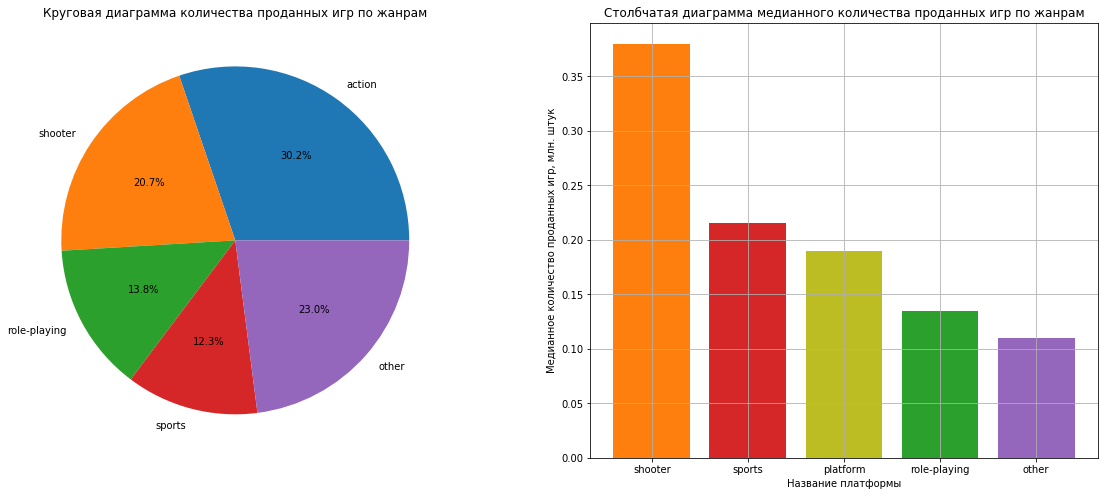

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for ax, aggfunc in zip(axes, ['sum', 'median']):
    column = 'total_sales_' + aggfunc
    actual_games_genres = actual_games_genres.sort_values(by=column, ascending=False).reset_index(drop=True)
    
    plot_labels = list(actual_games_genres.loc[:3, 'genre'])
    plot_labels.append('other')
    
    plot_data = list(actual_games_genres.loc[:3, column])
    
    if aggfunc == 'sum':
        plot_data.append(actual_games_genres.loc[4:, column].sum())
        ax.pie(x=plot_data, labels=plot_labels, autopct='%1.1f%%')
        ax.set_title('Круговая диаграмма количества проданных игр по жанрам')
    else:
        plot_data.append(actual_games_genres.loc[4:, column].median())
        ax.bar(plot_labels, plot_data, color=['tab:orange', 'tab:red', 'tab:olive', 'tab:green', 'tab:purple'])
        ax.set_title('Столбчатая диаграмма медианного количества проданных игр по жанрам')
        ax.set_xlabel('Название платформы')
        ax.set_ylabel('Медианное количество проданных игр, млн. штук')
        ax.grid()

fig.show()

По суммарному количеству проданных игр лидируют жанры Action, Shooter, Role-playing и Sports. Это говорит нам о популярности жанров.  

Однако на столбчатой диаграмме видно, что хоть жанр Shooter и уступает в популярности, игры данного жанра в среднем продаются гораздо лучше игр жанра Action (игры данного жанра даже не попали в топ-4).  

В контексте нашей задачи (планирование кампании на 2017 год) стоит руководствоваться именно медианными продажами. Игра жанра Shooter или Sports при прочих равных принесет большее количество продаж.

#### Вывод

1. Больше всего игр издавалось в период с 2007 года по 2011 год
2. Период устаревания консолей - 5-7 лет
3. Самые перспективные платформы: PlayStation4 (ps4), Xbox One (xone), 3DS (3ds) и PC (pc)
4. Влияние оценок критиков на продажи не очень велико. Оценки пользователей практически не влияют на продажи
5. 4 самых популярных жанра: action, shooter, role-playing и sports.  
6. 4 жанра, игры в которых в среднем продаются лучше: shooter, sports, platform и role-playing.

Для упрощения восприятия была построена соответствующая визуализация.

### Портрет пользователя для каждого региона

Рассматриваются 3 региона:
- North America (Северная Америка)
- Europe (Европа)
- Japan (Япония)

Необходимость выделения регионов возникает из-за разных игровых предпочтений пользователей из разных регионов.  

Для пользователей каждого региона определим:
- Топ-5 популярных платформ
- Топ-5 популярных жанров
- Влияние рейтинга на продажи  

Составим функции для автоматизации.

In [31]:
def top_n_popular(column, region, n):
    return list(actual_games.groupby(column)[region+'_sales'].sum().sort_values(ascending=False).head(n).index)

In [32]:
for column in ['platform', 'genre']:
    for region in ['na', 'eu', 'jp']:
        print(f'Топ-5 популярных {"платформ" if column == "platform" else "жанров"} в регионе {region} {top_n_popular(column, region, 5)}')

Топ-5 популярных платформ в регионе na ['x360', 'ps4', 'ps3', 'xone', '3ds']
Топ-5 популярных платформ в регионе eu ['ps4', 'ps3', 'x360', 'xone', '3ds']
Топ-5 популярных платформ в регионе jp ['3ds', 'ps3', 'psv', 'ps4', 'wiiu']
Топ-5 популярных жанров в регионе na ['action', 'shooter', 'sports', 'role-playing', 'misc']
Топ-5 популярных жанров в регионе eu ['action', 'shooter', 'sports', 'role-playing', 'racing']
Топ-5 популярных жанров в регионе jp ['role-playing', 'action', 'misc', 'simulation', 'fighting']


Видно, что между пользователями из Северной Америки и Европы минимальные различия. А вот предпочтения пользователей из Японии отличаются достаточно сильно. Видимо, самобытность Японской культуры находит отражение и в игровой индустрии.  

Оценим влияние возрастного рейтинга на продажи игр.  
Построим диаграмму, отображающую количество проданных игр того или иного рейтинга для каждого региона.

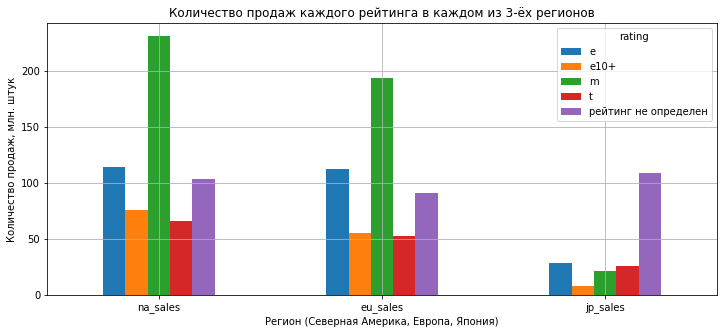

In [33]:
actual_games.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum().T.plot(kind='bar', figsize=(12, 5), grid=True)
plt.xticks(rotation=0)
plt.xlabel('Регион (Северная Америка, Европа, Япония)')
plt.ylabel('Количество продаж, млн. штук')
plt.title('Количество продаж каждого рейтинга в каждом из 3-ёх регионов')
plt.show()

Cокращения названий возрастных групп:
- e - Everyone (6+)
- e10+ - Everyone 10 and older (10+)
- t - Teen (13+)
- m - Mature (17+)

В Европе и Америке больше всего продаются игры самой строгой возрастной группой из представленных (m - Mature 17+). А в Японии в основном покупаются игры с неопределенным рейтингом. Среди определенных рейтингов преобладают игры с низким возрастным рейтингом.  

Построим таблицу коэффициентов корреляции. Сокращения названий возрастных групп заменим на числа, соответствующие возрасту группы. Это необходимо для нахождения коэффициентов корреляции.

In [34]:
actual_games_rating_corr = actual_games[actual_games['rating'] != 'рейтинг не определен']

actual_games_rating_corr['rating_corr'] = actual_games_rating_corr['rating']

actual_games_rating_corr['rating_corr'].replace({'e': 6, 'e10+': 10, 't': 13, 'm': 17}, inplace=True)

actual_games_rating_corr[['eu_sales', 'na_sales', 'jp_sales', 'rating_corr']].corr().reset_index().loc[3:3, 'index':'jp_sales']

,index,eu_sales,na_sales,jp_sales
3,rating_corr,0.062848,0.093393,-0.03939


Возрастной рейтинг практически не влияет на количество продаж.

#### Вывод

Портреты пользователей из Северной Америки и Европы практически не различаются. Портрет пользователей из Японии отличается достаточно сильно.  
Предпочтения платформ в порядке уменьшения популярности:
- Список популярных платформ в Европе: ps4, ps3, x360, xone, 3ds
- Список популярных платформ в Северной Америке: x360, ps4, ps3, xone, 3ds
- Список популярных платформ в Японии: 3ds, ps3, psv, ps4, wiiu.

Предпочтения жанров в порядке уменьшения популярности:
- Список популярных жанров в Европе: action, shooter, sports, role-playing, racing
- Список популярных жанров в Северной Америке: action, shooter, sports, role-playing, misc
- Список популярных жанров в Японии: role-playing, action, misc, simulation, fighting  

Возрастная категория практически не влияет на продажи игр.

#### Проверка гипотез

Необходимо проверить следующие гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action и Sports разные

В обоих случаях будем используется метод scipy.stats.ttest_ind(), так как он используется для проверки равенства средных двух выборок одной генеральной совокупности.  
Также в обоих случаях будем проверять двухсторонние гипотезы, так как нам важно проверить только равенство/неравенство.

Зададим критический уровень статистической значимости равный 0.05, так как в данном случае нет оснований для изменения этого параметра, так как наши исследования не обладают какой-то критической важностью.  

Для удоства создадим функцию проверки гипотез.

Начнем с первой гипотезы. Сформируем основную и альтернативную гипотезы.  

**H0** - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.  
**Н1** - Средние пользовательские рейтинги платформ Xbox One и PC различаются.  

Создадим функцию.

In [35]:
def check_hyp(sample_1, sample_2, equal_var=False, alpha=0.05):
    print(f'Среднее значение первой выборки: {sample_1.mean():.2f}')
    print(f'Среднее значение второй выборки: {sample_2.mean():.2f}')
    
    results = st.ttest_ind(sample_1, sample_2, equal_var=equal_var)

    print('p-значение:', results.pvalue)

    if (results.pvalue < alpha):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Сформируем выборки.

In [36]:
xbox_scores = actual_games.loc[(actual_games['platform'] == 'xone'), 'users_score'].dropna()
pc_scores = actual_games.loc[(actual_games['platform'] == 'pc'), 'users_score'].dropna()

Проведем проверку. Выборки достаточно велики, поэтому оставим параметр equal_var равным False.

In [37]:
check_hyp(xbox_scores, pc_scores)

Среднее значение первой выборки: 6.52
Среднее значение второй выборки: 6.43
p-значение: 0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


Возможности отвергуть нулевую гипотезу нет. Видимо, пользовательские оценки игр на платформах Xbox One и PC одинаковы. А разницу между ними считаем случайной.

Проверим вторую гипотезу. Сформируем основную и альтернативную гипотезы.  

**H0** - Средние пользовательские рейтинги жанров Action и Sports одинаковы.  
**Н1** - Средние пользовательские рейтинги жанров Action и Sports различаются.  

Сформируем выборки.

In [38]:
action_scores = actual_games.loc[(actual_games['genre'] == 'action'), 'users_score'].dropna()
sports_scores = actual_games.loc[(actual_games['genre'] == 'sports'), 'users_score'].dropna()

Проведем проверку. Выборки достаточно велики, поэтому оставим параметр equal_var равным False.

In [39]:
check_hyp(action_scores, sports_scores)

Среднее значение первой выборки: 6.83
Среднее значение второй выборки: 5.46
p-значение: 4.24307776572644e-20
Отвергаем нулевую гипотезу


Нулевую гипотезу отвергаем. Следовательно, гипотеза о том, что средние пользовательские оценки жанров action и sports различаются, подтвеждается.

#### Вывод

Проверялись 2 гипотезы:
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
- Средние пользовательские рейтинги жанров Action и Sports разные

Обе гипотезы были приняты.  

Для проверки использовался метод scipy.stats.ttest_ind(), обе гипотезы были двухсторонними. Параметр equal_var установили в False, так как на больших выборках результаты работы метода scipy.stats.ttest_ind() практически не зависят от значения параметра equal_var.  
Критический уровень статистической значимости установили в 0.05.

### Общий вывод

Была проведена подготовка данных:
- Удалены строки-мусор
- Значения 'tbd' столбца users_score были заменены на NaN
- Пропуски в возрастном рейтинге заменены на 'рейтинг не определен'
- Все текстовые значения всех столбцов переведены в нижний регистр
- Отредактированы названя столбцов  
- Был добавлен столбец total_sales, содержащий суммарные продажи игры

Исследовательский анализ показал:
- Больше всего игр издавалось в период с 2007 года по 2011 год
- Период устаревания консолей - 5-7 лет
- Самые перспективные платформы: PlayStation4 (ps4), Xbox One (xone), 3DS (3ds) и PC (pc)
- Влияние оценок критиков на продажи не очень велико. Оценки пользователей практически не влияют на продажи
- 4 самых популярных жанра: action, shooter, role-playing и sports.  

Жанровые предпочтения и предпочтения платформ пользователей из Северной Америки и Европы практически не различаются. Предпочтения пользователей из Японии отличаются достаточно сильно.  
Возрастной рейтинг не влияет на продажи игр.  

Проверялись 2 гипотезы: 
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
- Средние пользовательские рейтинги жанров Action и Sports разные  
Обе гипотезы были прняты.  

**Рекомендации** по планированию кампании на 2017 год:  
Между европейским и северо-американским регионом практически нет различий. Американский рынок немного больше.

In [40]:
print(f'Американский рынок больше на {actual_games["na_sales"].sum() / actual_games["eu_sales"].sum() - 1:.2%}')

Американский рынок больше на 16.60%


Основные отличия между этими рынками - предпочтения в спортивных играх. В Америке любят Американский футбол и Хоккей, а в Европе футбол.  

На этих рынках стоит ориентироваться на игры жанра Action, Shooter, Sports и Role-playing.  
Среди платформ надо ориентироваться на консоли последнего поколения (PS4, Xbox One), мобильную платформу 3DS и на персональные компьютеры PC.  
Возрастная категория не станет препятствием.

**Японский рынок** сильно отличается от Западного.

Тут стоит ориентироваться на игры жанра Role-playing, Action, Misc, Simulation, Fighting.  
В Японии сильно развиты мобильные игровые платформы, поэтому нельзя обходить вниманием платформы 3DS, PSV и WIIU. Платформа PS4 достаточно популярна.  
В Японии может помешать возрастной рейтинг. Там плохо покупают игры с высоким возрастным рейтингом.